# Abalone Rings Regression using CNN

In [44]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [45]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [46]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values

In [47]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [48]:
class AbaloneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [49]:
train_dataset = AbaloneDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = AbaloneDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataset = AbaloneDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [50]:
class AbaloneRegressionConv1D(nn.Module):
    def __init__(self):
        super(AbaloneRegressionConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = AbaloneRegressionConv1D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [52]:
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        train_total += labels.size(0)
    train_losses.append(train_loss / train_total)

    net.eval()
    val_loss = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            val_total += labels.size(0)
    val_losses.append(val_loss / val_total)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

Epoch [100/1000], Train Loss: 10.2267, Validation Loss: 5.2729
Epoch [200/1000], Train Loss: 9.4647, Validation Loss: 5.2834
Epoch [300/1000], Train Loss: 7.2857, Validation Loss: 4.9679
Epoch [400/1000], Train Loss: 5.7931, Validation Loss: 4.7316
Epoch [500/1000], Train Loss: 5.0489, Validation Loss: 5.2755
Epoch [600/1000], Train Loss: 4.6715, Validation Loss: 5.1117
Epoch [700/1000], Train Loss: 4.1409, Validation Loss: 5.3948
Epoch [800/1000], Train Loss: 3.7951, Validation Loss: 5.1471
Epoch [900/1000], Train Loss: 3.4854, Validation Loss: 5.1592
Epoch [1000/1000], Train Loss: 3.3586, Validation Loss: 5.1769


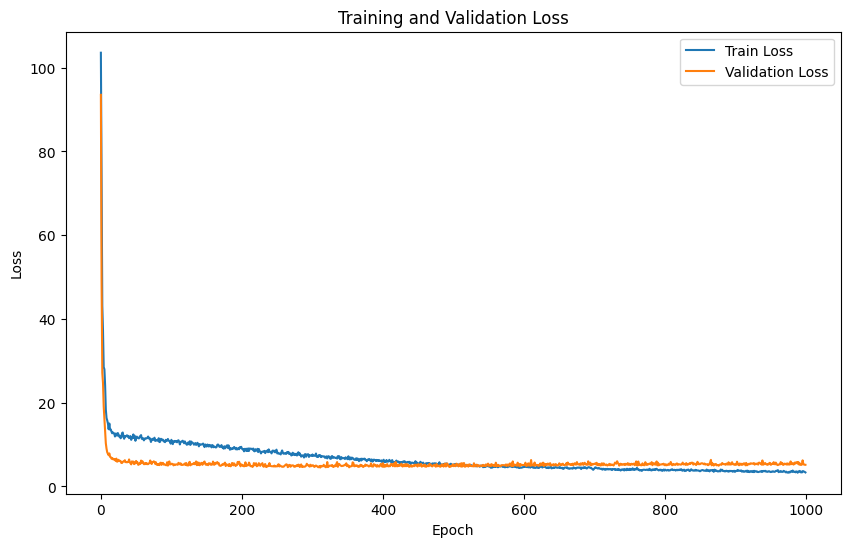

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

In [54]:
net.eval()
with torch.no_grad():
    y_pred = net(X_test_tensor).numpy().flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Final Results:')
print(f'\tMean Absolute Error: {mae:.4f}')
print(f'\tMean Squared Error: {mse:.4f}')
print(f'\tr2 Score: {r2:.4f}')

Final Results:
	Mean Absolute Error: 1.6453
	Mean Squared Error: 5.3214
	r2 Score: 0.4760


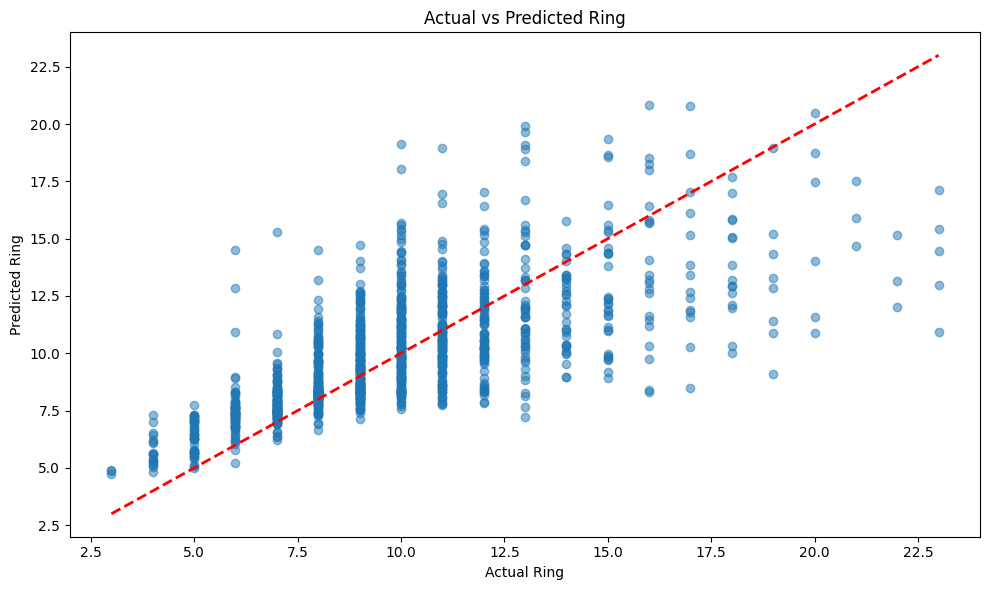

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ring')
plt.ylabel('Predicted Ring')
plt.title('Actual vs Predicted Ring')
plt.tight_layout()
plt.show()
plt.close()

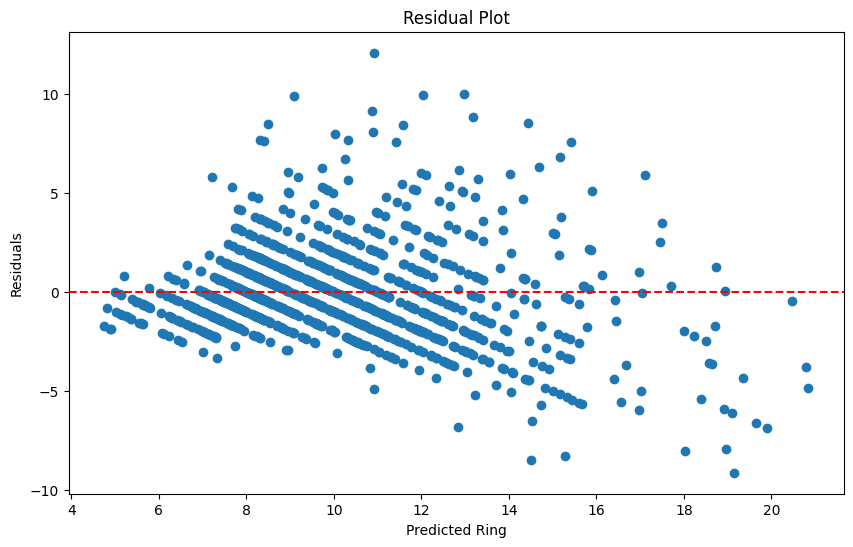

In [56]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Ring')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
plt.close()

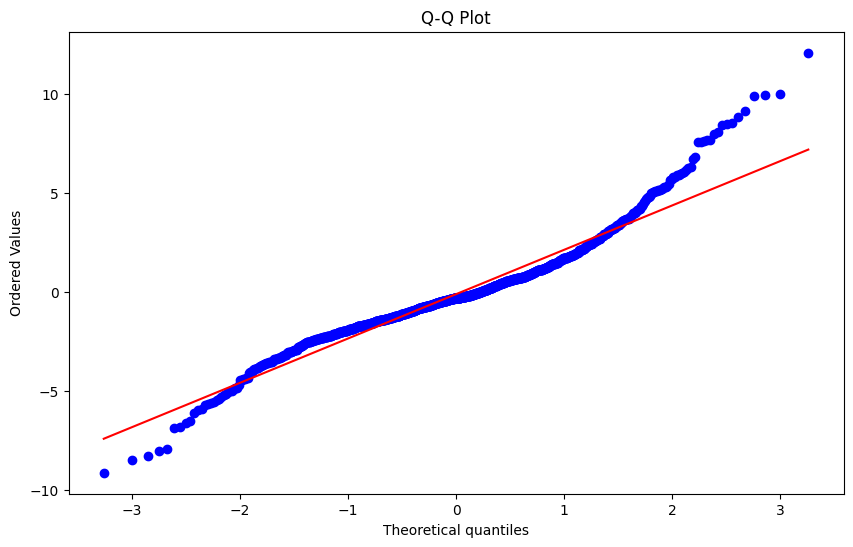

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot")
plt.show()
plt.close()

In [58]:
feature_importance = []
for i in range(8):
    X_test_mod = X_test_scaled.copy()
    X_test_mod[:, i] = 0
    X_test_mod_tensor = torch.FloatTensor(X_test_mod).unsqueeze(1).to(device)
    with torch.no_grad():
        y_pred_mod = net(X_test_mod_tensor).numpy().flatten()
    mse_mod = mean_squared_error(y_test, y_pred_mod)
    importance = mse_mod - mse
    feature_importance.append(importance)

feature_importance = pd.DataFrame({
    'feature': data.drop(['Rings', 'id'], axis=1).columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
          feature  importance
5  Shucked_weight   10.346096
4    Whole_weight    8.455821
6  Viscera_weight    2.658893
2        Diameter    1.929206
1          Length    1.282000
3          Height    1.024836
7    Shell_weight    1.018724
0             Sex    0.421408
